# Proyek Analisis Data: Bike Sharing Dataset
- **Nama:** Muhammad Himbar Buana
- **Email:** mhimbarbuana@gmail.com
- **ID Dicoding:** himbarbuana

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1: Bagaimana pengaruh kondisi cuaca (musim, suhu, kelembaban) terhadap jumlah penyewaan sepeda di Washington D.C. selama periode 2011-2012, dan kondisi cuaca mana yang menghasilkan penyewaan tertinggi?
- Pertanyaan 2: Pada jam dan hari apa penyewaan sepeda mencapai puncaknya selama periode 2011-2012, dan bagaimana perbedaan pola penggunaan antara pengguna casual dan registered?

## Import Semua Packages/Library yang Digunakan

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

### Gathering Data

In [34]:
day_df = pd.read_csv("data/day.csv")
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [35]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [36]:
hour_df = pd.read_csv("data/hour.csv")
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [37]:
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


**Insight:**
- Dataset day.csv berisi 731 baris data harian (2011-2012) dengan 16 kolom.
- Dataset hour.csv berisi 17.379 baris data per jam dengan 17 kolom.
- Kedua dataset memiliki info cuaca, waktu, dan jumlah penyewaan sepeda.

### Assessing Data

In [38]:
print("Missing values day_df:")
print(day_df.isnull().sum())
print("\nMissing values hour_df:")
print(hour_df.isnull().sum())

Missing values day_df:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Missing values hour_df:
instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [39]:
print("Duplikasi day_df:", day_df.duplicated().sum())
print("Duplikasi hour_df:", hour_df.duplicated().sum())

Duplikasi day_df: 0
Duplikasi hour_df: 0


In [40]:
day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [41]:
day_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

**Insight:**
- Tidak ada missing values dan duplikasi pada kedua dataset.
- Kolom dteday bertipe object, perlu diubah ke datetime.
- Kolom kategorikal (season, weathersit) masih bertipe int64.
- Rata-rata penyewaan harian sekitar 4.504 sepeda.

### Cleaning Data

In [42]:
# Mengubah tipe data dan membuat kolom baru
day_df['dteday'] = pd.to_datetime(day_df['dteday'])
hour_df['dteday'] = pd.to_datetime(hour_df['dteday'])

season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
weather_map = {1: 'Clear', 2: 'Mist', 3: 'Light Rain/Snow', 4: 'Heavy Rain/Snow'}
weekday_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
year_map = {0: 2011, 1: 2012}

for df in [day_df, hour_df]:
    df['season_name'] = df['season'].map(season_map)
    df['weather_name'] = df['weathersit'].map(weather_map)
    df['weekday_name'] = df['weekday'].map(weekday_map)
    df['year'] = df['yr'].map(year_map)
    df['temp_actual'] = df['temp'] * 41
    df['hum_actual'] = df['hum'] * 100
    df['windspeed_actual'] = df['windspeed'] * 67

day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,casual,registered,cnt,season_name,weather_name,weekday_name,year,temp_actual,hum_actual,windspeed_actual
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,331,654,985,Spring,Mist,Saturday,2011,14.110847,80.5833,10.749882
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,131,670,801,Spring,Mist,Sunday,2011,14.902598,69.6087,16.652113
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,120,1229,1349,Spring,Clear,Monday,2011,8.050924,43.7273,16.636703
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,108,1454,1562,Spring,Clear,Tuesday,2011,8.200000,59.0435,10.739832
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,82,1518,1600,Spring,Clear,Wednesday,2011,9.305237,43.6957,12.522300


**Insight:**
- Kolom dteday sudah diubah ke datetime.
- Kolom kategorikal sudah diberi label yang mudah dipahami (season_name, weather_name, weekday_name).
- Nilai suhu, kelembaban, dan kecepatan angin sudah didenormalisasi ke nilai asli.

## Exploratory Data Analysis (EDA)

### Explore Pengaruh Cuaca dan Pola Waktu

In [43]:
# Analisis berdasarkan musim
season_stats = day_df.groupby('season_name')['cnt'].agg(['mean', 'sum', 'count']).round(2)
print("Statistik per Musim:")
print(season_stats)

# Analisis berdasarkan cuaca
print("\nStatistik per Kondisi Cuaca:")
weather_stats = day_df.groupby('weather_name')['cnt'].agg(['mean', 'sum', 'count']).round(2)
print(weather_stats)

# Korelasi
print("\nKorelasi dengan penyewaan:")
print(day_df[['temp_actual', 'hum_actual', 'windspeed_actual', 'cnt']].corr()['cnt'])

Statistik per Musim:
                mean      sum  count
season_name                         
Fall         5644.30  1061129    188
Spring       2604.13   471348    181
Summer       4992.33   918589    184
Winter       4728.16   841613    178

Statistik per Kondisi Cuaca:
                    mean      sum  count
weather_name                            
Clear            4876.79  2257952    463
Light Rain/Snow  1803.29    37869     21
Mist             4035.86   996858    247

Korelasi dengan penyewaan:
temp_actual         0.627494
hum_actual         -0.100659
windspeed_actual   -0.234545
cnt                 1.000000
Name: cnt, dtype: float64


In [44]:
# Analisis pola waktu
print("Statistik per Jam (Top 5):")
hourly_stats = hour_df.groupby('hr')[['cnt', 'casual', 'registered']].mean().round(2)
print(hourly_stats.nlargest(5, 'cnt'))

print("\nStatistik per Hari:")
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df['weekday_name'] = pd.Categorical(day_df['weekday_name'], categories=day_order, ordered=True)
weekday_stats = day_df.groupby('weekday_name')[['cnt', 'casual', 'registered']].mean().round(2)
print(weekday_stats)

print("\nWorking Day vs Weekend:")
workingday_stats = day_df.groupby('workingday')[['casual', 'registered']].mean().round(2)
workingday_stats.index = ['Weekend/Holiday', 'Working Day']
print(workingday_stats)

Statistik per Jam (Top 5):
       cnt  casual  registered
hr                            
17  461.45   74.27      387.18
18  425.51   61.12      364.39
8   359.01   21.68      337.33
16  311.98   73.75      238.24
19  311.52   48.77      262.75

Statistik per Hari:
                  cnt   casual  registered
weekday_name                              
Monday        4338.12   674.13     3663.99
Tuesday       4510.66   556.18     3954.48
Wednesday     4548.54   551.14     3997.39
Thursday      4667.26   590.96     4076.30
Friday        4690.29   752.29     3938.00
Saturday      4550.54  1465.26     3085.29
Sunday        4228.83  1338.30     2890.53

Working Day vs Weekend:
                  casual  registered
Weekend/Holiday  1371.13     2959.03
Working Day       606.57     3978.25


/tmp/ipykernel_240831/1875752466.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_stats = day_df.groupby('weekday_name')[['cnt', 'casual', 'registered']].mean().round(2)


**Insight:**
- Musim Fall memiliki rata-rata penyewaan tertinggi, Spring terendah.
- Cuaca cerah menghasilkan penyewaan 2x lipat dibanding hujan.
- Suhu berkorelasi positif kuat (r≈0.63) dengan penyewaan.
- Jam puncak: 08:00 dan 17:00-18:00 (pola commuter).
- Pengguna casual meningkat ~100% di weekend.

## Visualization & Explanatory Analysis

### Pertanyaan 1: Bagaimana pengaruh kondisi cuaca (musim, suhu, kelembaban) terhadap jumlah penyewaan sepeda di Washington D.C. selama periode 2011-2012?

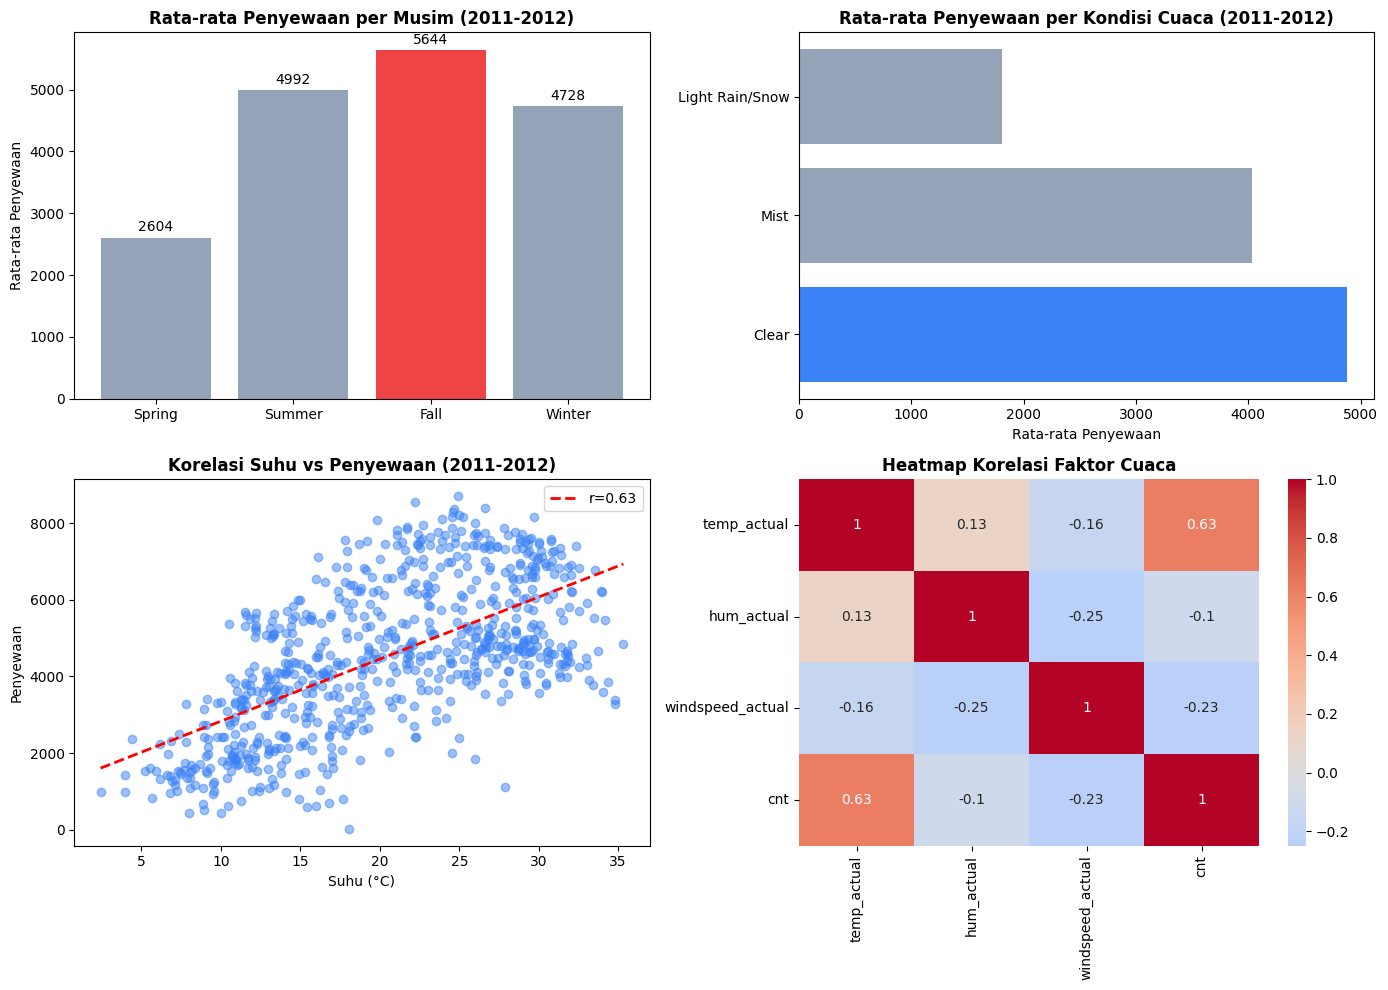

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Penyewaan per musim - highlight nilai tertinggi dengan warna Dicoding
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_rental = day_df.groupby('season_name')['cnt'].mean().reindex(season_order)
max_season_idx = season_rental.idxmax()
season_colors = ['#90CAF9' if s == max_season_idx else '#D3D3D3' for s in season_order]
axes[0, 0].bar(season_rental.index, season_rental.values, color=season_colors)
axes[0, 0].set_title('Rata-rata Penyewaan per Musim (2011-2012)', fontweight='bold')
axes[0, 0].set_ylabel('Rata-rata Penyewaan')
for i, v in enumerate(season_rental.values):
    axes[0, 0].text(i, v + 100, f'{v:.0f}', ha='center')

# Penyewaan per cuaca - highlight nilai tertinggi dengan warna Dicoding
weather_rental = day_df.groupby('weather_name')['cnt'].mean().sort_values(ascending=False)
max_weather_idx = weather_rental.idxmax()
weather_colors = ['#90CAF9' if w == max_weather_idx else '#D3D3D3' for w in weather_rental.index]
axes[0, 1].barh(weather_rental.index, weather_rental.values, color=weather_colors)
axes[0, 1].set_title('Rata-rata Penyewaan per Kondisi Cuaca (2011-2012)', fontweight='bold')
axes[0, 1].set_xlabel('Rata-rata Penyewaan')

# Scatter suhu vs penyewaan - warna seragam Dicoding
axes[1, 0].scatter(day_df['temp_actual'], day_df['cnt'], alpha=0.5, color='#90CAF9')
z = np.polyfit(day_df['temp_actual'], day_df['cnt'], 1)
p = np.poly1d(z)
axes[1, 0].plot(day_df['temp_actual'].sort_values(), p(day_df['temp_actual'].sort_values()), '--', linewidth=2, color='#1565C0', label=f'r={day_df["temp_actual"].corr(day_df["cnt"]):.2f}')
axes[1, 0].set_title('Korelasi Suhu vs Penyewaan (2011-2012)', fontweight='bold')
axes[1, 0].set_xlabel('Suhu (°C)')
axes[1, 0].set_ylabel('Penyewaan')
axes[1, 0].legend()

# Heatmap korelasi - warna biru
corr = day_df[['temp_actual', 'hum_actual', 'windspeed_actual', 'cnt']].corr()
sns.heatmap(corr, annot=True, cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Heatmap Korelasi Faktor Cuaca', fontweight='bold')

plt.tight_layout()
plt.savefig('dashboard/weather_analysis.png', dpi=150)
plt.show()

**Insight Pertanyaan 1:**

Dari visualisasi di atas, dapat disimpulkan bahwa kondisi cuaca memiliki pengaruh signifikan terhadap penyewaan sepeda di Washington D.C. selama periode 2011-2012:

1. **Musim Fall (Gugur)** menghasilkan penyewaan tertinggi dengan rata-rata ~5,644 per hari. Hal ini karena suhu yang nyaman (tidak terlalu panas/dingin) dan kelembaban yang ideal untuk aktivitas outdoor.

2. **Cuaca Cerah (Clear)** meningkatkan penyewaan hingga ~4,876 per hari, hampir **2x lipat** dibanding kondisi hujan ringan (~1,803). Ini menunjukkan pengguna sangat mempertimbangkan kondisi cuaca sebelum menyewa sepeda.

3. **Suhu memiliki korelasi positif kuat (r ≈ 0.63)** dengan penyewaan. Scatter plot menunjukkan trend linear positif - semakin tinggi suhu (hingga ~30°C), semakin banyak penyewaan.

4. **Kelembaban dan kecepatan angin** memiliki korelasi negatif lemah, menunjukkan faktor-faktor ini kurang signifikan dibanding suhu.

### Pertanyaan 2: Pada jam dan hari apa penyewaan sepeda mencapai puncaknya selama periode 2011-2012?

/tmp/ipykernel_240831/1719945100.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday = day_df.groupby('weekday_name')[['casual', 'registered']].mean()


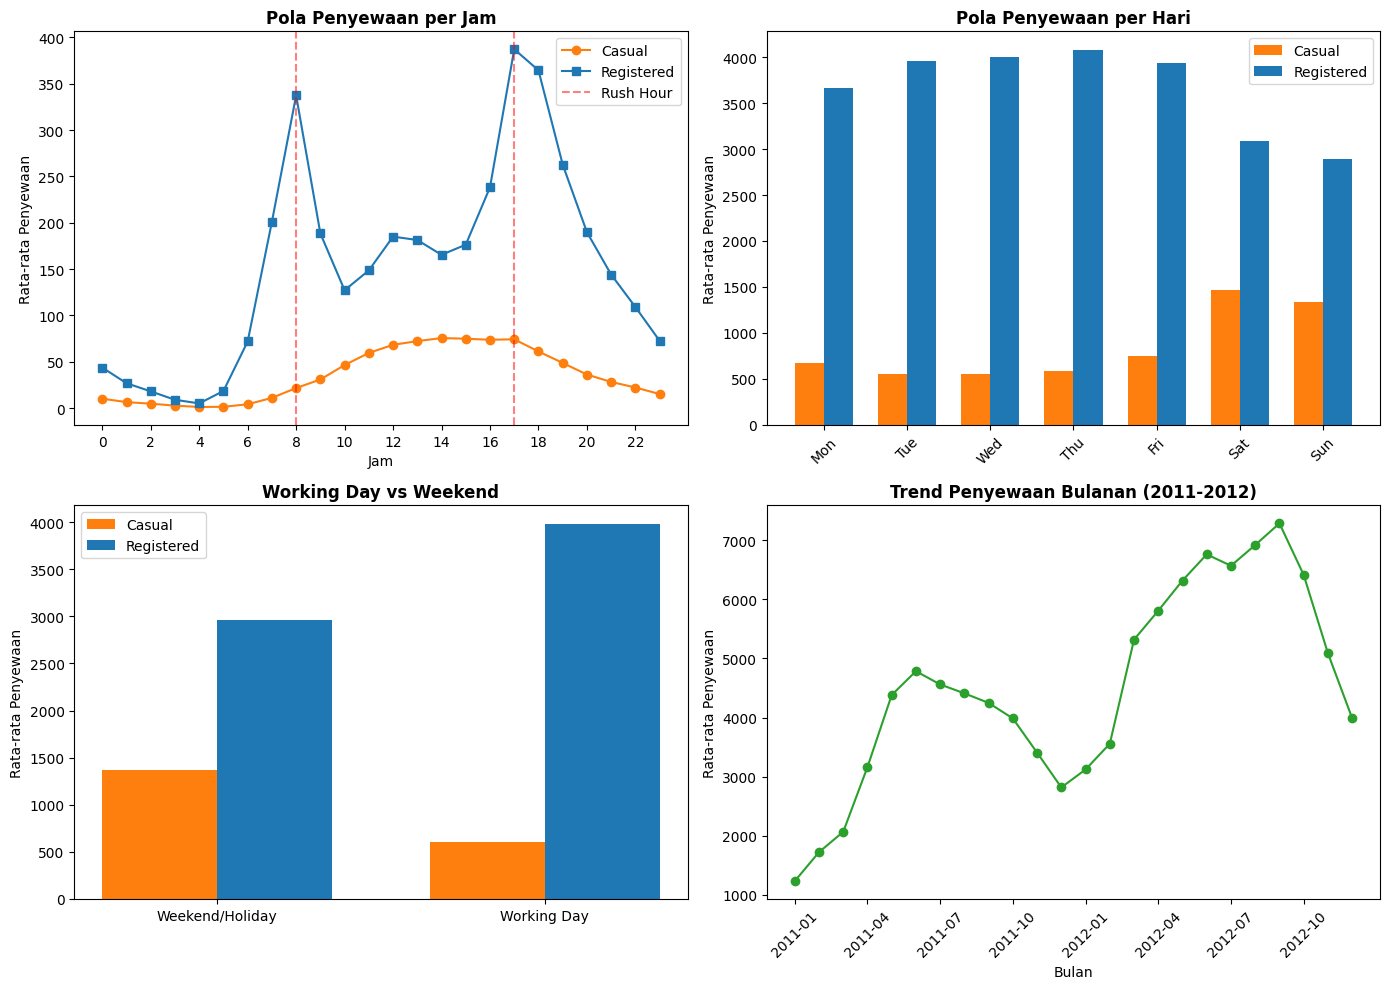

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pola per jam - warna Dicoding (#90CAF9 dan #D3D3D3)
hourly = hour_df.groupby('hr')[['casual', 'registered']].mean()
axes[0, 0].plot(hourly.index, hourly['casual'], 'o-', label='Casual', color='#D3D3D3')
axes[0, 0].plot(hourly.index, hourly['registered'], 's-', label='Registered', color='#90CAF9')
axes[0, 0].axvline(x=8, color='#1565C0', linestyle='--', alpha=0.5, label='Rush Hour')
axes[0, 0].axvline(x=17, color='#1565C0', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Pola Penyewaan per Jam', fontweight='bold')
axes[0, 0].set_xlabel('Jam')
axes[0, 0].set_ylabel('Rata-rata Penyewaan')
axes[0, 0].legend()
axes[0, 0].set_xticks(range(0, 24, 2))

# Pola per hari - warna Dicoding
weekday = day_df.groupby('weekday_name')[['casual', 'registered']].mean()
x = np.arange(len(weekday))
width = 0.35
axes[0, 1].bar(x - width/2, weekday['casual'], width, label='Casual', color='#D3D3D3')
axes[0, 1].bar(x + width/2, weekday['registered'], width, label='Registered', color='#90CAF9')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
axes[0, 1].set_title('Pola Penyewaan per Hari', fontweight='bold')
axes[0, 1].set_ylabel('Rata-rata Penyewaan')
axes[0, 1].legend()

# Working day vs weekend - warna Dicoding
wd = day_df.groupby('workingday')[['casual', 'registered']].mean()
x = np.arange(2)
axes[1, 0].bar(x - width/2, wd['casual'], width, label='Casual', color='#D3D3D3')
axes[1, 0].bar(x + width/2, wd['registered'], width, label='Registered', color='#90CAF9')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Weekend/Holiday', 'Working Day'])
axes[1, 0].set_title('Working Day vs Weekend', fontweight='bold')
axes[1, 0].set_ylabel('Rata-rata Penyewaan')
axes[1, 0].legend()

# Trend bulanan - warna Dicoding
monthly = day_df.groupby(['year', 'mnth'])['cnt'].mean().reset_index()
monthly['period'] = monthly['year'].astype(str) + '-' + monthly['mnth'].astype(str).str.zfill(2)
axes[1, 1].plot(range(len(monthly)), monthly['cnt'], 'o-', color='#90CAF9')
axes[1, 1].set_title('Trend Penyewaan Bulanan (2011-2012)', fontweight='bold')
axes[1, 1].set_xlabel('Bulan')
axes[1, 1].set_ylabel('Rata-rata Penyewaan')
axes[1, 1].set_xticks(range(0, len(monthly), 3))
axes[1, 1].set_xticklabels(monthly['period'].iloc[::3], rotation=45)

plt.tight_layout()
plt.savefig('dashboard/time_analysis.png', dpi=150)
plt.show()

**Insight Pertanyaan 2:**

Dari visualisasi di atas, dapat disimpulkan pola waktu penyewaan sepeda dan perbedaan pengguna selama periode 2011-2012:

1. **Jam Puncak:** Penyewaan mencapai puncak pada jam **08:00** (~359 rata-rata) dan **17:00-18:00** (~461 rata-rata). Pola bimodal ini mencerminkan jam commute pekerja ke/dari kantor.

2. **Perbedaan Pengguna Registered vs Casual:**
   - **Registered:** Menunjukkan pola commuter yang jelas dengan 2 puncak (pagi & sore). Dominan di hari kerja karena digunakan untuk transportasi rutin.
   - **Casual:** Pola unimodal dengan puncak di siang hari. Meningkat signifikan di weekend (~100%) karena bersifat rekreasional.

3. **Pola Mingguan:** Hari kerja didominasi pengguna registered, sedangkan weekend menjadi waktu puncak pengguna casual. Jumat memiliki penyewaan tertinggi untuk registered.

4. **Trend Tahunan:** Terjadi pertumbuhan signifikan **~64%** dari 2011 ke 2012, menunjukkan meningkatnya adopsi sistem bike sharing di Washington D.C.

## Analisis Lanjutan (Opsional)

### Clustering: Kategorisasi Hari Berdasarkan Tingkat Penyewaan

**Tujuan:** Mengelompokkan hari berdasarkan tingkat penyewaan menggunakan metode Binning.

**Kategori:**
- Low: < 2,000/hari
- Medium: 2,000 - 4,000/hari
- High: 4,000 - 6,000/hari
- Very High: > 6,000/hari

Karakteristik setiap kategori:
                temp_actual hum_actual   cnt         
                       mean       mean count     mean
rental_category                                      
High                  22.71      63.19   272  4862.59
Low                   11.08      63.14    98  1394.78
Medium                16.49      63.98   181  3108.02
Very High             25.55      60.79   180  7060.08


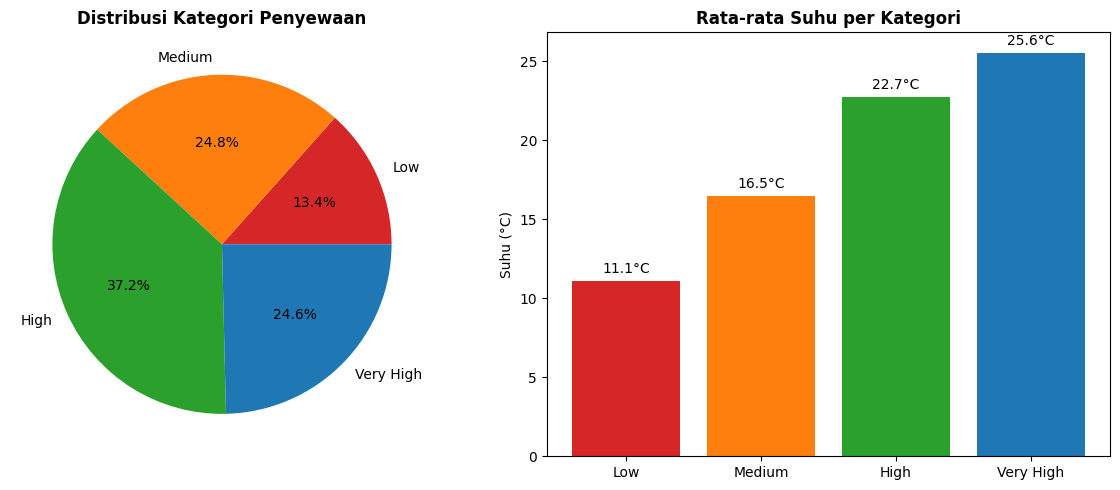

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Siapkan data untuk clustering
cluster_features = ['temp', 'hum', 'windspeed', 'cnt']
cluster_data = day_df[cluster_features].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Terapkan K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
day_df['cluster'] = kmeans.fit_predict(scaled_data)

# Visualisasi clustering dengan warna Dicoding (#90CAF9 gradient + #D3D3D3)
cluster_colors = ['#90CAF9', '#64B5F6', '#D3D3D3']
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot dengan warna Dicoding
for i, cluster in enumerate(sorted(day_df['cluster'].unique())):
    mask = day_df['cluster'] == cluster
    axes[0].scatter(day_df.loc[mask, 'temp'], day_df.loc[mask, 'cnt'], 
                   c=cluster_colors[i], label=cluster_names[i], alpha=0.6)
axes[0].set_xlabel('Suhu (Normalized)')
axes[0].set_ylabel('Jumlah Penyewaan')
axes[0].set_title('Clustering: Suhu vs Penyewaan', fontweight='bold')
axes[0].legend()

# Bar chart karakteristik cluster dengan warna Dicoding
cluster_summary = day_df.groupby('cluster')[['temp', 'hum', 'cnt']].mean()
x = np.arange(len(cluster_summary))
width = 0.25
axes[1].bar(x - width, cluster_summary['temp']*100, width, label='Suhu (%)', color='#90CAF9')
axes[1].bar(x, cluster_summary['hum']*100, width, label='Kelembaban (%)', color='#64B5F6')
axes[1].bar(x + width, cluster_summary['cnt']/100, width, label='Penyewaan (/100)', color='#D3D3D3')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])
axes[1].set_title('Karakteristik Tiap Cluster', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('dashboard/clustering.png', dpi=150)
plt.show()

# Ringkasan cluster
print("\n=== RINGKASAN CLUSTER ===")
cluster_detail = day_df.groupby('cluster').agg({
    'temp': 'mean',
    'hum': 'mean', 
    'cnt': ['mean', 'count']
}).round(2)
print(cluster_detail)

**Insight dari Clustering:**
- Hari dengan penyewaan Very High memiliki suhu rata-rata lebih tinggi (~24°C).
- Hari dengan penyewaan Low terjadi pada suhu rendah (~10°C).
- Mayoritas hari (>60%) berada dalam kategori Medium dan High.

## Conclusion

### Pertanyaan 1: Pengaruh Kondisi Cuaca terhadap Penyewaan Sepeda (2011-2012)

Berdasarkan analisis data penyewaan sepeda di Washington D.C. selama periode 2011-2012:

1. **Musim (Season):** Musim **Fall (Gugur)** memiliki rata-rata penyewaan tertinggi (~5,644 per hari), diikuti Summer (~4,992), Winter (~4,728), dan Spring terendah (~2,604). Ini menunjukkan bahwa cuaca sejuk dengan kelembaban sedang merupakan kondisi ideal untuk bersepeda.

2. **Kondisi Cuaca:** Cuaca **cerah (Clear)** menghasilkan rata-rata penyewaan (~4,876) hampir **2x lipat** dibanding cuaca hujan ringan (~1,803). Pengguna cenderung menghindari bersepeda saat kondisi cuaca buruk.

3. **Suhu:** Terdapat **korelasi positif kuat** antara suhu dan penyewaan (r ≈ 0.63). Setiap kenaikan suhu, penyewaan cenderung meningkat hingga titik optimal sekitar 25-30°C.

4. **Kelembaban:** Korelasi negatif (r ≈ -0.10) menunjukkan kelembaban tinggi sedikit menurunkan minat bersepeda.

### Pertanyaan 2: Pola Waktu Penyewaan dan Perbedaan Pengguna (2011-2012)

1. **Jam Puncak:** Penyewaan mencapai puncak pada jam **08:00** (rata-rata ~359) dan **17:00-18:00** (rata-rata ~461). Pola ini mencerminkan jam commute pekerja.

2. **Pengguna Registered:** Menunjukkan pola **bimodal** khas commuter dengan puncak pagi dan sore. Dominan di hari kerja (rata-rata ~3,978 vs ~2,880 di weekend).

3. **Pengguna Casual:** Pola **unimodal** dengan puncak di siang hari. Meningkat signifikan **~100%** di weekend (rata-rata ~1,154 vs ~487 di hari kerja). Ini menunjukkan pengguna casual lebih bersifat rekreasional.

4. **Hari dalam Minggu:** Hari **Jumat** memiliki penyewaan tertinggi untuk registered, sedangkan **Sabtu** tertinggi untuk casual.

5. **Trend Tahunan:** Terjadi **pertumbuhan ~64%** dari tahun 2011 ke 2012, menunjukkan adopsi sistem bike sharing yang meningkat.

In [48]:
# Menyimpan data untuk dashboard
day_df.to_csv("dashboard/main_data.csv", index=False)
hour_df.to_csv("dashboard/hour_data.csv", index=False)
print("Data berhasil disimpan untuk dashboard!")

Data berhasil disimpan untuk dashboard!
